<a href="https://colab.research.google.com/github/mansiraturi/tnbc_Detection/blob/main/TNBCDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn.model_selection import train_test_split
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

**Load & Handle Gene Features**

In [ ]:
clinical= pd.read_csv('/content/drive/MyDrive/content/brca_tcga_clinical_data.tsv', delimiter="\t")

In [ ]:
genes = genes = pd.read_csv('/content/drive/MyDrive/content/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', delimiter="\t")
#genes = genes = pd.read_csv('/content/drive/MyDrive/content/mrna.csv')

In [ ]:
genes.shape

(20531, 1102)

In [ ]:
genes.head()

,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,LOC100130426,100130426,-1.7608,-1.7608,1.1240,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,...,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608
1,UBE2Q2P3,100133144,1.0944,0.3540,0.6451,0.6963,-0.0246,-0.6627,-2.9270,-1.6563,...,-2.4538,-0.5741,-2.9270,-0.2765,-2.9270,-2.9270,0.9240,1.5101,-1.2605,-0.0175
2,UBE2Q2P3,100134869,1.0230,1.4736,0.5206,0.7910,1.1891,1.1002,0.7244,0.4830,...,1.1830,0.7643,-0.9748,1.1829,-0.0262,-0.9051,1.7984,2.1743,0.1793,2.0240
3,HMGB1P1,10357,-1.7033,-1.0056,0.9114,0.7418,-0.5522,0.1842,0.2208,0.0383,...,0.5990,0.6079,-3.0182,0.4649,-1.6364,-2.2051,0.6371,-1.2071,-0.5285,1.1111
4,TIMM23,10431,-2.5248,-1.6307,0.8069,-0.4455,-0.7821,-0.6367,0.2389,0.9257,...,1.2029,2.8887,1.4583,-1.0420,0.5612,1.6977,-1.2260,-0.9444,0.3174,-0.0360


In [ ]:
## Set aside gene name to numerical id for mapping
gene_map = genes.iloc[:, 0:2]

**Drop ESR1 (estrogen receptor), PGR (progesterone receptor), ERBB2 (HER2 receptor) genes to prevent data leakage**

In [ ]:
## First check if the 3 genes are in the data
genes_list = ["ESR1", "PGR", "ERBB2"]
[g in genes["Hugo_Symbol"].values for g in genes_list]

[True, True, True]

In [ ]:
## Next, drop the 3 genes from the dataframe
genes = genes.loc[~genes["Hugo_Symbol"].isin(genes_list), :]

In [ ]:
## Check: all should be False
[g in genes["Hugo_Symbol"].values for g in genes_list]

[False, False, False]

In [ ]:
# drop rows with duplicate id
genes = genes.drop_duplicates(subset="Entrez_Gene_Id")
genes.index = genes["Entrez_Gene_Id"]
genes = genes.iloc[:, 2:] #drop gene id cols
genes.head(5)

,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5L-AAT1-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,TCGA-A1-A0SD-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
Entrez_Gene_Id,,,,,,,,,,,,,,,,,,,,,
100130426,-1.7608,-1.7608,1.1240,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,...,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608
100133144,1.0944,0.3540,0.6451,0.6963,-0.0246,-0.6627,-2.9270,-1.6563,1.0087,0.3881,...,-2.4538,-0.5741,-2.9270,-0.2765,-2.9270,-2.9270,0.9240,1.5101,-1.2605,-0.0175
100134869,1.0230,1.4736,0.5206,0.7910,1.1891,1.1002,0.7244,0.4830,1.1853,0.8236,...,1.1830,0.7643,-0.9748,1.1829,-0.0262,-0.9051,1.7984,2.1743,0.1793,2.0240
10357,-1.7033,-1.0056,0.9114,0.7418,-0.5522,0.1842,0.2208,0.0383,0.2289,-1.3569,...,0.5990,0.6079,-3.0182,0.4649,-1.6364,-2.2051,0.6371,-1.2071,-0.5285,1.1111
10431,-2.5248,-1.6307,0.8069,-0.4455,-0.7821,-0.6367,0.2389,0.9257,-1.2069,-0.1077,...,1.2029,2.8887,1.4583,-1.0420,0.5612,1.6977,-1.2260,-0.9444,0.3174,-0.0360


In [ ]:
#Transpose dataframe such that each row=patient(observation), each col represents gene(feature)
genes = genes.transpose()
genes.head() #preview again

Entrez_Gene_Id,100130426,100133144,100134869,10357,10431,136542,155060,26823,280660,317712,...,7789,158586,79364,440590,79699,7791,23140,26009,387590,389932
TCGA-3C-AAAU-01,-1.7608,1.0944,1.0230,-1.7033,-2.5248,NaN,2.6672,-1.9754,-1.0239,-3.8503,...,1.6674,1.3652,1.7323,1.1787,1.0112,0.0077,1.2480,0.7011,-2.2857,-1.0151
TCGA-3C-AALI-01,-1.7608,0.3540,1.4736,-1.0056,-1.6307,NaN,1.4841,0.6553,-0.5570,-3.8503,...,0.0469,-0.2845,0.8841,0.9389,-0.8990,0.9335,0.3568,-1.8110,1.7416,-1.0151
TCGA-3C-AALJ-01,1.1240,0.6451,0.5206,0.9114,0.8069,NaN,1.6791,-1.9754,-1.0239,-3.8503,...,-1.0439,0.0704,-1.3588,1.4057,-1.2453,0.9163,-0.4675,-1.2802,-0.4957,-1.0151
TCGA-3C-AALK-01,-1.7608,0.6963,0.7910,0.7418,-0.4455,NaN,1.5817,-0.7379,-1.0239,-3.8503,...,-0.1270,-0.3346,-0.8902,0.8269,-0.8818,1.0020,-0.9299,-0.5286,-0.0672,-1.0151
TCGA-4H-AAAK-01,-1.7608,-0.0246,1.1891,-0.5522,-0.7821,NaN,0.5166,-0.7082,-1.0239,-3.8503,...,-0.3710,-0.3982,-0.1067,-1.4182,-0.2086,0.2990,-0.7752,0.0127,0.6400,-1.0151


In [ ]:
genes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1100 entries, TCGA-3C-AAAU-01 to TCGA-Z7-A8R6-01
Columns: 20502 entries, 100130426 to 389932
dtypes: float64(20502)
memory usage: 172.1+ MB


Clinical Dataset

In [ ]:
clinical.head(5)

,Study ID,Patient ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,...,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Time between clamping and freezing,Time between excision and freezing,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Vial number
0,brca_tcga,TCGA-3C-AAAU,TCGA-3C-AAAU-01,55.0,MX,NX,Stage X,6th,TX,NaN,...,NaN,NaN,NaN,Modified Radical Mastectomy,NaN,NaN,3C,NaN,WITH TUMOR,A
1,brca_tcga,TCGA-3C-AALI,TCGA-3C-AALI-01,50.0,M0,N1a,Stage IIB,6th,T2,NaN,...,NaN,NaN,NaN,Lumpectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
2,brca_tcga,TCGA-3C-AALJ,TCGA-3C-AALJ-01,62.0,M0,N1a,Stage IIB,7th,T2,NaN,...,NaN,NaN,NaN,Modified Radical Mastectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
3,brca_tcga,TCGA-3C-AALK,TCGA-3C-AALK-01,52.0,M0,N0 (i+),Stage IA,7th,T1c,NaN,...,NaN,NaN,NaN,Simple Mastectomy,NaN,NaN,3C,NaN,TUMOR FREE,A
4,brca_tcga,TCGA-4H-AAAK,TCGA-4H-AAAK-01,50.0,M0,N2a,Stage IIIA,7th,T2,NaN,...,NaN,NaN,NaN,Modified Radical Mastectomy,NaN,NaN,4H,NaN,TUMOR FREE,A


In [ ]:
#For both the datasets, we will match them with patient ID later for our analysis and prediction
clinical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Columns: 141 entries, Study ID to Vial number
dtypes: float64(49), int64(2), object(90)
memory usage: 1.2+ MB


In [ ]:
clinical.describe()

,Diagnosis Age,Neoplasm American Joint Committee on Cancer Clinical Group Stage,Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage,Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage,Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage,Days to Sample Collection.,Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value,days_to_patient_progression_free,Days to Sample Procurement,days_to_tumor_progression,...,Sample Initial Weight,Sample type id,Shortest Dimension,Specimen Current Weight,Specimen Freezing Means,Specimen Second Longest Dimension,Stage Other,Time between clamping and freezing,Time between excision and freezing,TMB (nonsynonymous)
count,1103.000000,0.0,0.0,0.0,0.0,1097.000000,1103.0,0.0,0.0,0.0,...,1100.000000,1108.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,982.000000
mean,58.355394,NaN,NaN,NaN,NaN,1063.051960,0.0,NaN,NaN,NaN,...,300.002727,1.031588,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.213476
std,13.241396,NaN,NaN,NaN,NaN,1443.312197,0.0,NaN,NaN,NaN,...,263.544104,0.396341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.097823
min,26.000000,NaN,NaN,NaN,NaN,16.000000,0.0,NaN,NaN,NaN,...,5.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033333
25%,49.000000,NaN,NaN,NaN,NaN,149.000000,0.0,NaN,NaN,NaN,...,130.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667
50%,58.000000,NaN,NaN,NaN,NaN,447.000000,0.0,NaN,NaN,NaN,...,210.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.066667
75%,67.000000,NaN,NaN,NaN,NaN,1372.000000,0.0,NaN,NaN,NaN,...,370.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.900000
max,90.000000,NaN,NaN,NaN,NaN,7858.000000,0.0,NaN,NaN,NaN,...,2190.000000,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,147.100000


In [ ]:
clinical.dtypes

Study ID                                                     object
Patient ID                                                   object
Sample ID                                                    object
Diagnosis Age                                               float64
American Joint Committee on Cancer Metastasis Stage Code     object
                                                             ...   
Time between excision and freezing                          float64
Tissue Source Site                                           object
TMB (nonsynonymous)                                         float64
Person Neoplasm Status                                       object
Vial number                                                  object
Length: 141, dtype: object

In [ ]:
clinical.shape

(1108, 141)

In [ ]:
clinical.columns

Index(['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age',
       'American Joint Committee on Cancer Metastasis Stage Code',
       'Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code',
       'Neoplasm Disease Stage American Joint Committee on Cancer Code',
       'American Joint Committee on Cancer Publication Version Type',
       'American Joint Committee on Cancer Tumor Stage Code',
       'Brachytherapy first reference point administered total dose',
       ...
       'Staging System.1', 'Surgery for positive margins',
       'Surgery for positive margins other', 'Surgical procedure first',
       'Time between clamping and freezing',
       'Time between excision and freezing', 'Tissue Source Site',
       'TMB (nonsynonymous)', 'Person Neoplasm Status', 'Vial number'],
      dtype='object', length=141)

Categorising features

In [ ]:
#numerical features
num_ft = [ft for ft in clinical.columns if clinical[ft].dtypes!="O"]
print("There are",len(num_ft), " numerical features in the clinical dataset" )
for ft in num_ft:
  print(ft)

There are 51  numerical features in the clinical dataset
Diagnosis Age
Neoplasm American Joint Committee on Cancer Clinical Group Stage
Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage
Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage
Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage
Days to Sample Collection.
Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value
days_to_patient_progression_free
Days to Sample Procurement
days_to_tumor_progression
Disease Free (Months)
Lymphomatous Extranodal Site Involvement Indicator
Fraction Genome Altered
HER2 and cent17 cells count
HER2 cent17 counted cells count
HER2 cent17 ratio
HER2 ihc score
IHC Score
Year Cancer Initial Diagnosis
Longest Dimension
Positive Finding Lymph Node Hematoxylin and Eosin Staining Microscopy Count
Positive Finding Lymph Node Keratin Immunohistochemistry Staining Method Count
Lymph Node(s) Examined Number
First Patho

In [ ]:
#discrete features
dis_ft = [ft for ft in clinical.columns if ft in num_ft and clinical[ft].unique().sum()<25]
print("There are",len(dis_ft), " discrete features in the clinical dataset" )
for ft in dis_ft:
  print(ft)

There are 2  discrete features in the clinical dataset
Number of Samples Per Patient
Sample type id


In [ ]:
cont_ft = [ft for ft in clinical.columns if ft in num_ft and ft not in dis_ft]
print("There are",len(cont_ft), " continuous features in the clinical dataset" )
for ft in cont_ft:
  print(ft)

There are 49  continuous features in the clinical dataset
Diagnosis Age
Neoplasm American Joint Committee on Cancer Clinical Group Stage
Neoplasm American Joint Committee on Cancer Clinical Distant Metastasis M Stage
Neoplasm American Joint Committee on Cancer Clinical Regional Lymph Node N Stage
Neoplasm American Joint Committee on Cancer Clinical Primary Tumor T Stage
Days to Sample Collection.
Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value
days_to_patient_progression_free
Days to Sample Procurement
days_to_tumor_progression
Disease Free (Months)
Lymphomatous Extranodal Site Involvement Indicator
Fraction Genome Altered
HER2 and cent17 cells count
HER2 cent17 counted cells count
HER2 cent17 ratio
HER2 ihc score
IHC Score
Year Cancer Initial Diagnosis
Longest Dimension
Positive Finding Lymph Node Hematoxylin and Eosin Staining Microscopy Count
Positive Finding Lymph Node Keratin Immunohistochemistry Staining Method Count
Lymph Node(s) Examined Number
First Path

In [ ]:
#Considering only relevant features from the dataset
clinical_ft = [
    'Sample ID', #ids
    'Sample Type','Fraction Genome Altered', #tumor info
    'Diagnosis Age','Sex','Race Category','Ethnicity Category', #patient info
    'Informed consent verified', #ethics
    'ER Status By IHC','PR status by ihc','IHC-HER2' #required for CLASS LABEL
]
clinical = clinical[clinical_ft]
clinical.head()

,Sample ID,Sample Type,Fraction Genome Altered,Diagnosis Age,Sex,Race Category,Ethnicity Category,Informed consent verified,ER Status By IHC,PR status by ihc,IHC-HER2
0,TCGA-3C-AAAU-01,Primary,0.7787,55.0,Female,WHITE,NOT HISPANIC OR LATINO,YES,Positive,Positive,Negative
1,TCGA-3C-AALI-01,Primary,0.7164,50.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Positive
2,TCGA-3C-AALJ-01,Primary,0.5340,62.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Indeterminate
3,TCGA-3C-AALK-01,Primary,0.0764,52.0,Female,BLACK OR AFRICAN AMERICAN,NOT HISPANIC OR LATINO,YES,Positive,Positive,Positive
4,TCGA-4H-AAAK-01,Primary,0.2364,50.0,Female,WHITE,NOT HISPANIC OR LATINO,YES,Positive,Positive,Equivocal


**Categorising features**

In [ ]:
#categorical features
cat_ft = [ft for ft in clinical.columns if clinical[ft].dtypes=="O" and len(clinical[ft].unique())<25]
print("There are",len(cat_ft), "categorical features in the clinical dataset" )
for ft in cat_ft:
  print(ft)

There are 8 categorical features in the clinical dataset
Sample Type
Sex
Race Category
Ethnicity Category
Informed consent verified
ER Status By IHC
PR status by ihc
IHC-HER2


**Subset data & re-group features**

In [ ]:
#only considering data for female patients
clinical = clinical[(clinical["Sex"]=="Female") & (clinical["Sample Type"]=="Primary")]

In [ ]:
missing_ft = [ft for ft in clinical.columns if clinical[ft].isnull().sum()>1]
print("There are ", len(missing_ft) , "columns with missing values")
for ft in missing_ft:
  print(ft, np.round(clinical[ft].isnull().mean()*100, 3), "%")

There are  6 columns with missing values
Fraction Genome Altered 1.659 %
Race Category 8.664 %
Ethnicity Category 15.76 %
ER Status By IHC 4.516 %
PR status by ihc 4.608 %
IHC-HER2 16.221 %


In [ ]:
grp = clinical.groupby('Race Category').size()
grp

Race Category
AMERICAN INDIAN OR ALASKA NATIVE      1
ASIAN                                61
BLACK OR AFRICAN AMERICAN           180
WHITE                               749
dtype: int64

In [ ]:
#majority race of the patients is white so we study the relationship between these and categorise rest of the races as 'other category'
# clinical['RaceWhite'] = np.where(clinical['Race Category']=="WHITE", "White", "Other")
clinical['RaceWhite'] = (clinical['Race Category']=="WHITE")
clinical.loc[clinical['Race Category'].isna(), "RaceWhite"] = None

**Define class labels, 1 if a cancer is ER-negative, PR-negative, and HER2-negative; 0 otherwise**

In [ ]:
## Initialize the label definition:
clinical['Label'] = (clinical['ER Status By IHC']=='Negative') & \
                    (clinical['PR status by ihc']=='Negative') & \
                    (clinical['IHC-HER2']=='Negative')

In [ ]:
clinical.loc[:,['ER Status By IHC','PR status by ihc','IHC-HER2']].isna().sum()

ER Status By IHC     49
PR status by ihc     50
IHC-HER2            176
dtype: int64

In [ ]:
## Count the number of missing receptors in each patient or sample
clinical['no_receptor_missing'] = clinical.loc[:,['ER Status By IHC','PR status by ihc','IHC-HER2']].isna().sum(axis=1)
set(clinical['no_receptor_missing'].to_list()) #few as 0, up to all 3 missing

{0, 1, 2, 3}

In [ ]:
#Set any patient with 1+ receptor missing as Label=None
clinical.loc[clinical['no_receptor_missing']>0, "Label"] = None
sum(clinical['Label'].isna())

178

In [ ]:
## Then, re-set Label=0 from NaN if at least 1 receptor is NOT negative
label0 = ['Positive','Intermediate','Equivocal']

clinical.loc[clinical['ER Status By IHC'].isin(label0) | \
         clinical['PR status by ihc'].isin(label0) | \
         clinical['IHC-HER2'].isin(label0), "Label"] = 0

sum(clinical['Label'].isna())

83

In [ ]:
## Finally, exclude label-less rows (patients)
clinical = clinical.dropna(subset=['Label'])

In [ ]:
clinical.shape

(1002, 14)

In [ ]:
!pip install tableone

In [ ]:
from tableone import TableOne

selected_cols = ['Sex','RaceWhite','no_receptor_missing','Informed consent verified']

myTable1 = TableOne(
    clinical,
    columns = selected_cols,
    groupby = 'Label'
)

In [ ]:
clinical['Label'] = clinical['Label'].replace(True, 1)
clinical['Label'] = clinical['Label'].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Column 'True' or '1.0' means Class=1, i.e. the triple negative cancers
print(myTable1.tabulate(tablefmt="rst"))

================================  ======  =========  ============  ===========  ===========
..                                        Missing    Overall       0            True
================================  ======  =========  ============  ===========  ===========
n                                                    1002          886          116
Sex, n (%)                        Female  0          1002 (100.0)  886 (100.0)  116 (100.0)
RaceWhite, n (%)                  False   94         216 (23.8)    176 (22.0)   40 (36.7)
..                                True               692 (76.2)    623 (78.0)   69 (63.3)
no_receptor_missing, n (%)        0       0          907 (90.5)    791 (89.3)   116 (100.0)
..                                1                  95 (9.5)      95 (10.7)
Informed consent verified, n (%)  YES     0          1002 (100.0)  886 (100.0)  116 (100.0)
================================  ======  =========  ============  ===========  ===========


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sum(clinical['Sample ID'].isin(genes.index))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


999

In [ ]:
sum(genes.index.isin(clinical['Sample ID'])) #should match cell above

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


999

In [ ]:
clinical = clinical.loc[clinical['Sample ID'].isin(genes.index), :]
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
genes = genes.loc[clinical['Sample ID'],:]
genes.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20502)

In [ ]:
## Confirm mutually subsetted dataframes are also matched
all(genes.index == clinical['Sample ID'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [ ]:
nullgenes = genes.columns[genes.isna().any()].tolist()
len(nullgenes)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


319

In [ ]:
gene = genes.dropna(axis=1)
gene.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20183)

**EDA WITH RESPECT TO OTHER CATEGORICAL FEATURES**

In [ ]:
# for ft in cat_ft:
#   df = clinical.copy()
#    # Plot bar chart
#   # sns.countplot
#   df.groupby(ft)['Label'].value_counts().unstack().plot(kind='bar', stacked=True)
#   plt.xlabel(ft)
#   plt.ylabel("Count")
#   plt.title(f"TNBC Presence by {ft}")
#   plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


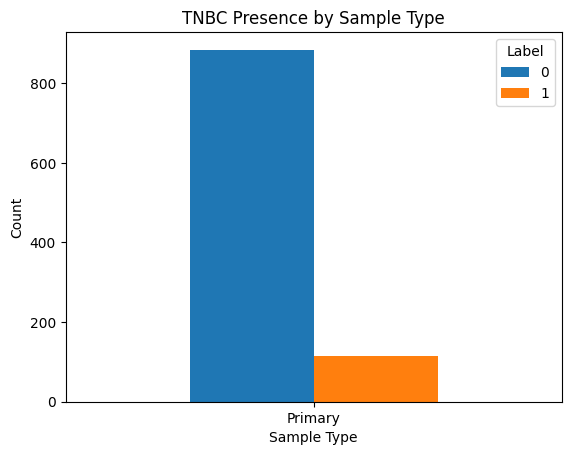

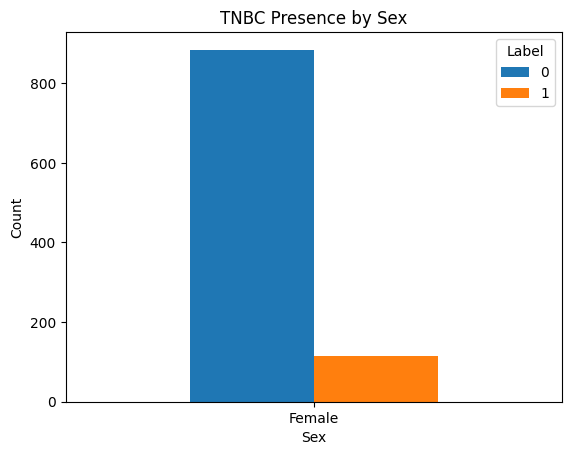

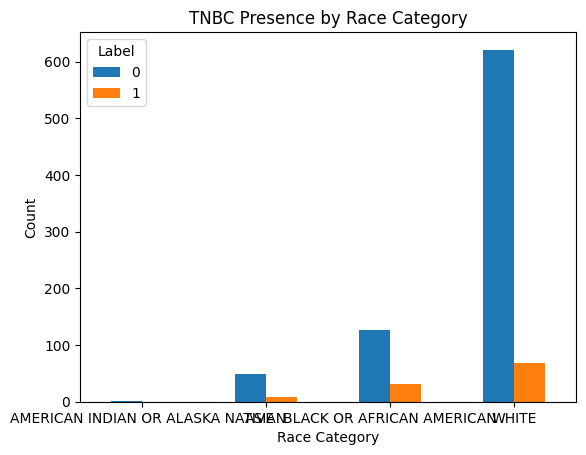

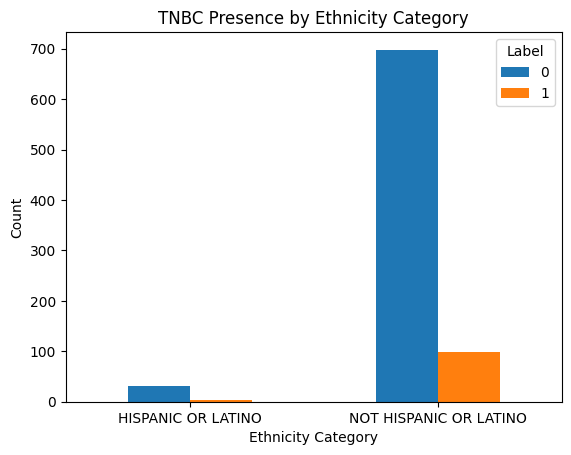

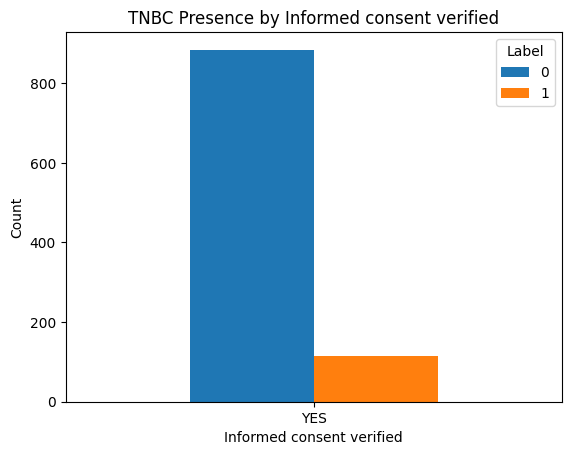

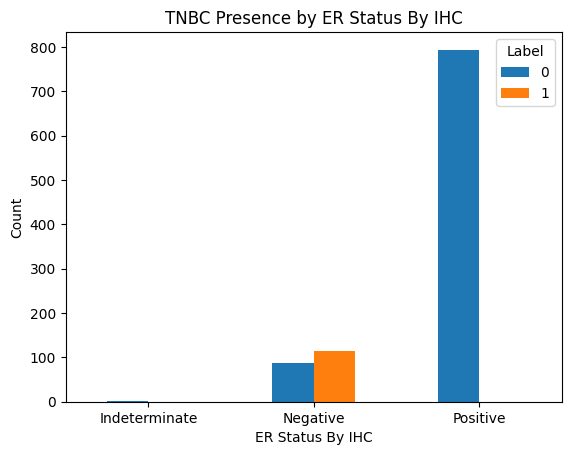

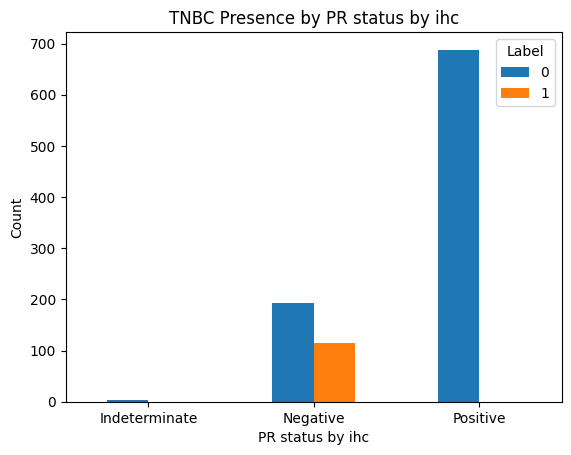

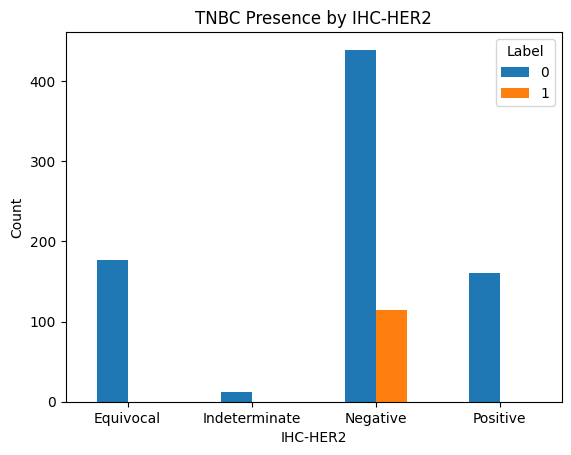

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for ft in cat_ft:
    df = clinical.copy()
    # Plot side by side bar chart
    grouped_data = df.groupby([ft, 'Label']).size().unstack(fill_value=0)
    grouped_data.plot(kind='bar', stacked=False)
    plt.xlabel(ft)
    plt.ylabel("Count")
    plt.title(f"TNBC Presence by {ft}")
    plt.legend(title='Label')
    plt.xticks(rotation=0)
    plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


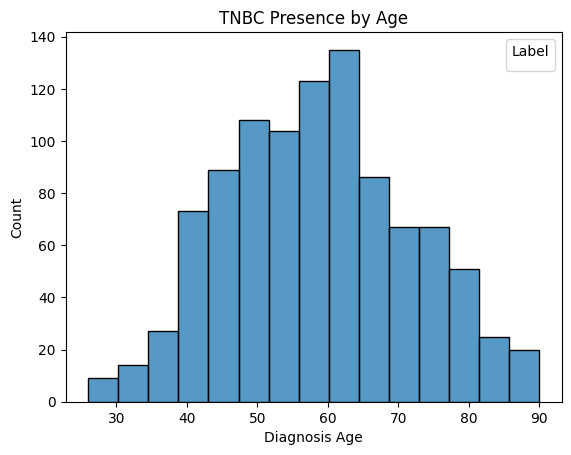

In [ ]:
filter_data = df[df['Label']==1]
sns.histplot(df['Diagnosis Age'], bins=15, kde=False)
plt.xlabel('Diagnosis Age')
plt.ylabel('Count')
plt.title('Scatter Plot of Age where Label=1')
plt.title(f"TNBC Presence by Age")
plt.legend(title='Label')
plt.xticks(rotation=0)
plt.show()

#Explore Data via Unsupervised Learning

In [ ]:
df.set_index('Sample ID', inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Merge based on the indices
merged_data = pd.merge(gene, df[['Label']], left_index=True, right_index=True, how='inner')
merged_data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,100130426,100133144,100134869,10357,10431,155060,26823,280660,317712,340602,...,158586,79364,440590,79699,7791,23140,26009,387590,389932,Label
TCGA-3C-AAAU-01,-1.7608,1.0944,1.0230,-1.7033,-2.5248,2.6672,-1.9754,-1.0239,-3.8503,0.0629,...,1.3652,1.7323,1.1787,1.0112,0.0077,1.2480,0.7011,-2.2857,-1.0151,0
TCGA-3C-AALI-01,-1.7608,0.3540,1.4736,-1.0056,-1.6307,1.4841,0.6553,-0.5570,-3.8503,3.6771,...,-0.2845,0.8841,0.9389,-0.8990,0.9335,0.3568,-1.8110,1.7416,-1.0151,0
TCGA-3C-AALJ-01,1.1240,0.6451,0.5206,0.9114,0.8069,1.6791,-1.9754,-1.0239,-3.8503,-0.8479,...,0.0704,-1.3588,1.4057,-1.2453,0.9163,-0.4675,-1.2802,-0.4957,-1.0151,0
TCGA-3C-AALK-01,-1.7608,0.6963,0.7910,0.7418,-0.4455,1.5817,-0.7379,-1.0239,-3.8503,-0.8479,...,-0.3346,-0.8902,0.8269,-0.8818,1.0020,-0.9299,-0.5286,-0.0672,-1.0151,0
TCGA-4H-AAAK-01,-1.7608,-0.0246,1.1891,-0.5522,-0.7821,0.5166,-0.7082,-1.0239,-3.8503,-0.5256,...,-0.3982,-0.1067,-1.4182,-0.2086,0.2990,-0.7752,0.0127,0.6400,-1.0151,0


In [ ]:
merged_data.columns = merged_data.columns.astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(merged_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


StandardScaler()

In [ ]:
scaled_data = scaler.transform(merged_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(scaled_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PCA(n_components=2)

In [ ]:
x_pca = pca.transform(scaled_data)
scaled_data.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20184)

In [ ]:
x_pca.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


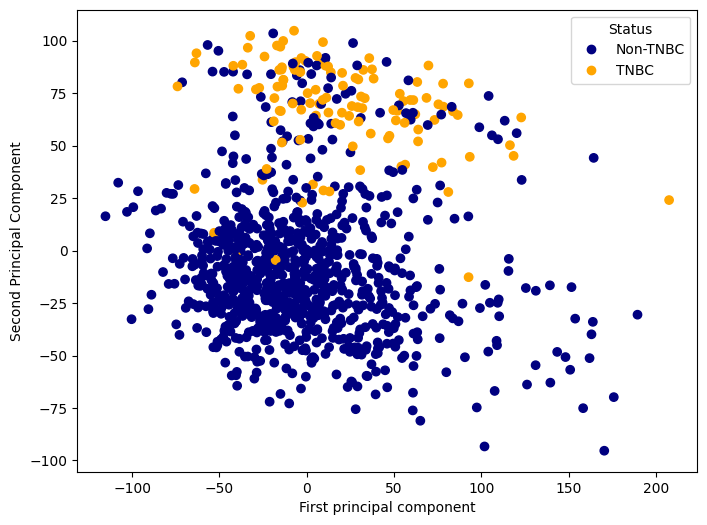

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['navy', 'orange'])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=merged_data['Label'], cmap=custom_cmap)

# Adding legend with custom labels
legend_labels = ['Non-TNBC', 'TNBC']
handles, _ = scatter.legend_elements()
plt.legend(handles=handles, title='Status', labels=legend_labels, loc='upper right')

plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')
plt.show()


In [ ]:
print("Variance captured by each feature:")
print(pca.explained_variance_ratio_)

Variance captured by each feature:
[0.10623094 0.07856377]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Feature Selection for Supervised Learning

In [ ]:
# Check to see if patient IDs in the 2 DataFrames match
all(genes.index == clinical['Sample ID'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

**Exclude genes with missing values**

In [ ]:
missing_genes = genes.columns[genes.isna().any()].tolist()
print(f"Percentage of missing genes: {len(missing_genes) / genes.shape[1]:.2f}" )

Percentage of missing genes: 0.02


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
genes = genes.dropna(axis=1)
genes.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 20183)

**Lasso Regression for Feature Selection**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Instantiate Lasso regression model
lasso = Lasso(alpha=0.03)  # You can adjust the alpha parameter as needed

# Fit the model
lasso.fit(genes, clinical["Label"].values)

# Select features using the trained Lasso model
model = SelectFromModel(lasso, prefit=True)
genes_selected = model.transform(genes)

# Shape of selected features
print("Shape of selected features:", genes_selected.shape)

# Set aside gene features selected
selected_features = genes.columns[model.get_support()]
print("Selected features (Entrez Gene IDs):", selected_features)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Shape of selected features: (999, 57)
Selected features (Entrez Gene IDs): Int64Index([    10551,    155465,     91074,      8537,    143379,    149563,
                57150,    401546,    401535,    158067,       771,       786,
                55450,     54901,    729767,      1131,     22866,      1363,
                27254,      1452,      1602,      2300,    161835,      2625,
                 9118,     10265,      3787,    606293,      4010, 100128191,
               285033,    164312,    116372,    284348,     79083,      9313,
               145957,     11165,    169611,     93210,     94026,      5460,
                25837,    255426,       388,      6017,      6627,    254122,
               222183,      7031,      3195,      7104,    157753,     11013,
                10103,      9654,      7368],
           dtype='int64', name='Entrez_Gene_Id')


In [ ]:
genes_lasso = pd.DataFrame(genes_selected)
genes_lasso.columns = selected_features #selected features
genes_lasso.index = genes.index #observations
genes_lasso.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entrez_Gene_Id,10551,155465,91074,8537,143379,149563,57150,401546,401535,158067,...,254122,222183,7031,3195,7104,157753,11013,10103,9654,7368
TCGA-3C-AAAU-01,-0.3382,0.7440,0.8410,0.5998,-1.3485,-2.1100,-0.6921,0.6167,-1.3062,0.2543,...,-0.8150,1.7296,-0.6914,0.7391,-0.5315,-1.3784,0.6873,1.1186,-0.8691,-1.7097
TCGA-3C-AALI-01,0.9688,0.8540,0.3367,1.6893,1.1354,-0.3955,-1.0560,0.4525,-0.7934,0.3772,...,-0.3699,0.7580,-0.3852,-1.1189,-0.6382,-0.8949,0.3087,0.1801,-0.8485,-0.8453
TCGA-3C-AALJ-01,0.3957,0.5845,1.1259,1.0173,-1.6026,-1.4954,-2.3766,-3.4345,-1.3062,0.4910,...,-0.6935,0.5507,-0.3153,-1.1189,-1.1524,-0.2267,1.0042,0.3831,-0.7447,-1.0931
TCGA-3C-AALK-01,0.6384,0.1980,0.8446,0.1889,0.3630,-0.1178,0.1833,0.8912,-0.1531,0.3688,...,-0.3610,0.6755,1.1335,-1.1189,0.3251,-0.9929,0.0023,0.6662,-0.1078,-0.0454
TCGA-4H-AAAK-01,0.2845,0.2268,0.4394,-0.0449,0.6868,0.9287,0.1617,0.6758,-0.1323,0.9663,...,0.8746,0.8174,0.8219,-1.1189,-0.7326,-0.4624,0.5726,-0.0912,-0.4827,-0.0001


In [ ]:
clinical.index = clinical['Sample ID'].values
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_lasso = clinical["Label"].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**L1-based Feature Selection**

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lsvc.fit(genes, clinical["Label"].astype(int).values)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LinearSVC(C=0.01, dual=False, penalty='l1')

In [ ]:
model = SelectFromModel(lsvc, prefit=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
genes_l1 = model.transform(genes)
genes_l1.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 43)

In [ ]:
## Set aside gene features selected
features_l1 = genes.columns[model.get_support()]
features_l1 #entrez gene Ids

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Int64Index([155465,  91074,    696, 143379,  83695, 149563,  57150, 401535,
               786, 729767,  22866,   1602,  51726,   2300,   2625,   9118,
              3787, 126823,  55915,   4010, 164312, 116372, 284348,  84789,
              9313, 193629, 169611,  93210, 255426,   6017, 140032,   6500,
             26781, 254122,   6725, 222183,   7031,   7104, 157753,  11013,
            131669, 646799,   7718],
           dtype='int64', name='Entrez_Gene_Id')

In [ ]:
len(features_l1) #should match genes_l1.shape[1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


43

In [ ]:
genes_l1 = pd.DataFrame(genes_l1)
genes_l1.columns = features_l1 #selected features
genes_l1.index = genes.index #observations
genes_l1.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Entrez_Gene_Id,155465,91074,696,143379,83695,149563,57150,401535,786,729767,...,254122,6725,222183,7031,7104,157753,11013,131669,646799,7718
TCGA-3C-AAAU-01,0.7440,0.8410,-0.5802,-1.3485,0.3491,-2.1100,-0.6921,-1.3062,-1.1856,-728.237,...,-0.8150,1.2954,1.7296,-0.6914,-0.5315,-1.3784,0.6873,2.0565,-0.5525,1.0571
TCGA-3C-AALI-01,0.8540,0.3367,-0.3288,1.1354,-0.0079,-0.3955,-1.0560,-0.7934,1.2827,-728.237,...,-0.3699,1.3304,0.7580,-0.3852,-0.6382,-0.8949,0.3087,1.0001,-0.1701,-0.6991
TCGA-3C-AALJ-01,0.5845,1.1259,-0.4364,-1.6026,0.4183,-1.4954,-2.3766,-1.3062,0.1288,-728.237,...,-0.6935,-1.0511,0.5507,-0.3153,-1.1524,-0.2267,1.0042,-0.1528,-1.3726,-0.0630
TCGA-3C-AALK-01,0.1980,0.8446,-0.2444,0.3630,0.1042,-0.1178,0.1833,-0.1531,0.5450,-728.237,...,-0.3610,0.5627,0.6755,1.1335,0.3251,-0.9929,0.0023,-0.2259,-0.4139,-0.7741
TCGA-4H-AAAK-01,0.2268,0.4394,-0.7818,0.6868,-1.5104,0.9287,0.1617,-0.1323,0.4103,-728.237,...,0.8746,-0.1779,0.8174,0.8219,-0.7326,-0.4624,0.5726,-1.2664,-0.3909,-0.3668


In [ ]:
clinical.index = clinical['Sample ID'].values
clinical.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(999, 14)

In [ ]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes.index == clinical.index)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
y_l1 = clinical["Label"].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Supervised Learning with SVM with Hyperparameter Tuning as Benchmark

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(genes_l1, y_l1, test_size=0.2, random_state=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class_weights = len(y_l1) / (2 * np.bincount(y_l1))
class_weights #balanced class weights

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.56504525, 4.34347826])

In [ ]:
## Relative positive class weight
class_weights[1] / class_weights[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.6869565217391305

In [ ]:
sum(y_l1 == 0) / sum(y_l1 == 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7.6869565217391305

**Train SVM with Hyperparameter Tuning**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats

NUM_CANDIDATES = 20
SVM_PARAMS = {'C': stats.expon(scale=100), 'gamma': stats.expon(scale=0.1)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
idx_validation = np.random.choice(range(X_train.shape[0]), size=200)
idx_train = np.setdiff1d(range(X_train.shape[0]), idx_validation)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
random_search = RandomizedSearchCV(
    SVC(max_iter = 20, kernel="rbf", class_weight='balanced'),
    param_distributions = SVM_PARAMS,
    n_iter = NUM_CANDIDATES,
    cv = [(idx_train, idx_validation)], #hold out validation
    scoring = "roc_auc"
)

random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomizedSearchCV(cv=[(array([  0,   3,   7,   9,  10,  12,  13,  14,  15,  16,  17,  19,  20,
        21,  22,  24,  25,  27,  28,  29,  30,  31,  32,  33,  34,  36,
        37,  38,  39,  40,  42,  45,  46,  47,  48,  51,  52,  53,  54,
        55,  56,  57,  58,  61,  62,  64,  65,  67,  68,  69,  71,  72,
        73,  74,  75,  76,  77,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  92,  93,  94,  95,  96,  97,  99, 100, 101,
       104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 116, 117, 118,
       119, 121, 122, 123, 124, 125, 127, 128, 130...
       428, 786, 712, 378, 588, 446, 315, 237,   4, 629, 704, 563,   5,
       595, 296, 634, 178, 485, 207, 615, 575, 289, 530,  26,  66, 598,
       706, 545, 512, 266, 141]))],
                   estimator=SVC(class_weight='balanced', max_iter=20),
                   n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d02eff5ee60>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d02eff0ffa0>},
                   scoring='roc_auc')

In [ ]:
df_tune = pd.DataFrame({
    "Hyperparam C": random_search.cv_results_["param_C"],
    "Hyperparam gamma": random_search.cv_results_["param_gamma"],
    "mean_AUC_score": random_search.cv_results_['mean_test_score']
})

df_tune.sort_values(by="mean_AUC_score", ascending=False, inplace=True)
df_tune

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Hyperparam C,Hyperparam gamma,mean_AUC_score
19,39.575266,0.021481,0.940501
16,9.76376,0.033594,0.932074
11,30.461578,0.013889,0.924668
10,221.868017,0.001509,0.920582
17,67.548567,0.03275,0.920327
13,104.439341,0.043107,0.915475
9,236.524036,0.108586,0.913432
7,4.000044,0.044859,0.912666
1,61.846455,0.064941,0.909346
15,83.258351,0.066039,0.908836


In [ ]:
#Verification
random_search.best_score_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9405005107252299

**Evaluation metrics on the Test Set**

In [ ]:
## Retrieve the best model:
svm = random_search.best_estimator_
yTestScore = svm.predict(X_test)
yTestPred = svm.predict(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(metrics.classification_report(y_test, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       179
           1       0.62      0.71      0.67        21

    accuracy                           0.93       200
   macro avg       0.80      0.83      0.81       200
weighted avg       0.93      0.93      0.93       200



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics import accuracy_score
print('SVM model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, yTestPred)))

SVM model accuracy score: 0.9250


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
## Confusion matrix
metrics.confusion_matrix(y_test, yTestPred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[170,   9],
       [  6,  15]])

In [ ]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# pip install scikit-plot

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(yTestScore)

[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_roc(ytrue, yscore):
    """ Wrapper to plot ROC curve for binary classification """
    from sklearn import metrics

    plt.figure(dpi=100)

    fpr, tpr, _ = metrics.roc_curve(ytrue, yscore)
    auc = metrics.roc_auc_score(ytrue, yscore)
    plt.plot(fpr,tpr,label="AUC=%.3f" % auc)
    plt.legend(loc=4)

    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


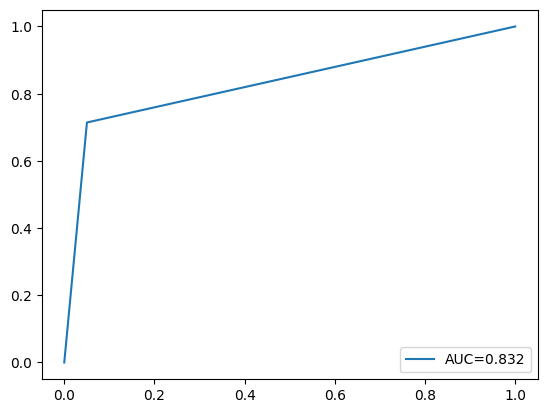

In [ ]:
plot_roc(y_test, yTestScore)

#Supervised Learning with XGBoost

In [ ]:
## Check to see if patient IDs in the 2 DataFrames match
assert all(genes_lasso.index == clinical.index)
y = clinical["Label"].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# genes = genes.loc[:,~genes.columns.duplicated()]
# X_train, X_val_test, y_train, y_val_test = train_test_split(genes, y_l1, test_size=0.2, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=100, random_state=42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
genes_lasso = genes_lasso.loc[:,~genes_lasso.columns.duplicated()]
X_train, X_test, y_train, y_test = train_test_split(genes_l1, y, test_size=0.2, random_state=0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 2nd split to get validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train.astype(int), test_size=0.2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
scale_pos_weight = sum(y== 0) / sum(y == 1)
print("Positive class weight = %.2f" % scale_pos_weight)

Positive class weight = 7.69


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class_weights = len(y) / (2 * np.bincount(y))
print("weight_0=%.2f, weight_1=%.2f" % tuple(class_weights))
print("sklearn version of class 1 weight %.2f" % (class_weights[1] / class_weights[0])) #should equal value in the cell above

weight_0=0.57, weight_1=4.34
sklearn version of class 1 weight 7.69


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# import machine learning libraries
import xgboost as xgb
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
params = {
    'max_depth':range(0,20),
    'eta':np.arange(0.05,0.5),
    'gamma':np.arange(0,2),
    'min_child_weight':range(2,10),
    'subsample':np.arange(0.5,0.9),
}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Run Hyperparameter Tuning via Random Search**

In [ ]:
#Hyperparameter optimization using RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost
classifier = xgboost.XGBClassifier()
rs_model=RandomizedSearchCV(classifier, param_distributions=params,n_iter=8,scoring='roc_auc',verbose=3,error_score='raise')
#model fitting
rs_model.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END eta=0.05, gamma=0, max_depth=15, min_child_weight=8, subsample=0.5;, score=0.981 total time=   0.1s
[CV 2/5] END eta=0.05, gamma=0, max_depth=15, min_child_weight=8, subsample=0.5;, score=0.942 total time=   0.1s
[CV 3/5] END eta=0.05, gamma=0, max_depth=15, min_child_weight=8, subsample=0.5;, score=0.941 total time=   0.1s
[CV 4/5] END eta=0.05, gamma=0, max_depth=15, min_child_weight=8, subsample=0.5;, score=0.975 total time=   0.1s
[CV 5/5] END eta=0.05, gamma=0, max_depth=15, min_child_weight=8, subsample=0.5;, score=0.973 total time=   0.1s
[CV 1/5] END eta=0.05, gamma=0, max_depth=13, min_child_weight=7, subsample=0.5;, score=0.971 total time=   0.1s
[CV 2/5] END eta=0.05, gamma=0, max_depth=13, min_child_weight=7, subsample=0.5;, score=0.939 total time=   0.1s
[CV 3/5] END eta=0.05, gamma=0, max_depth=13, min_child_weight=7, subsample=0.5;, score=0.946 total time=   0.1s
[CV 4/5] END eta=0.05, gamma=0, max_

RandomizedSearchCV(error_score='raise',
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=Non...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=8,
                   param_distributions={'eta': array([0.05]),
                                        'gamma': array([0, 1]),
                                        'max_depth': range(0, 20),
                                        'min_child_weight': range(2, 10),
                                        'subsample': array([0.5])},
                   scoring='roc_auc', verbose=3)

In [ ]:
#parameters selected
rs_model.best_estimator_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.05, eval_metric=None,
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
rs_model.best_score_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.9645446165191741

In [ ]:
#Building final classifier model
classifier=xgboost.XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.03, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=9,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(classifier,X_val,y_val)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(score)

[0.90625 0.90625 0.90625 0.90625 0.875  ]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
classifier.fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.03, eval_metric=None,
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=9, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, ...)

In [ ]:
yTestPred = classifier.predict(X_test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


**Evaluation metrics on the Test Set**

In [ ]:
# compute and print accuracy score
from sklearn.metrics import accuracy_score
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_test, yTestPred)))

XGBoost model accuracy score: 0.9550


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn import metrics

## Table of classification metrics
print(metrics.classification_report(y_test, yTestPred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       179
           1       0.83      0.71      0.77        21

    accuracy                           0.95       200
   macro avg       0.90      0.85      0.87       200
weighted avg       0.95      0.95      0.95       200



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(yTestPred)

[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


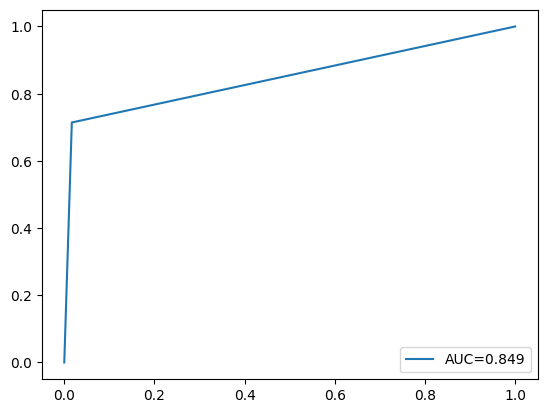

In [ ]:
plot_roc(y_test, yTestPred)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
